# Import

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
# tf.enable_eager_execution() # this is commented out, when using tf1.
print('TF Version = %s'%(tf.__version__))

TensorFlow 2.x selected.
TF Version = 2.1.0


In [0]:
!pip install -q --upgrade tensorflow-probability

In [3]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
print('TFP Version =%s'%(tfp.__version__))

TFP Version =0.9.0


In [4]:
import tensorflow
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import numpy as np
import sys
import time
import contextlib
import scipy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
%matplotlib inline
print('TF Keras Version = %s'%(tfk.__version__))

TF Keras Version = 2.2.4-tf


# Utils

In [0]:
@contextlib.contextmanager
def measure_time():
  start = time.time()
  try:
    yield
  finally:
    elapsed = time.time() - start
    print("\nElapsed Time %f [sec]"%(elapsed))

@contextlib.contextmanager
def overwriting_stdout():
  org_write = sys.stdout.write
  def overwrite(text):
    org_write("\r%s" % text)
    sys.stdout.flush()
  sys.stdout.write = overwrite
  try:
    yield
  finally:
    sys.stdout.write = org_write

# ODE Solver (TF)

In [0]:
def zip_map(zipped, update_op):
  return [update_op(*elems) for elems in zipped]

def euler_update(h_list, dh_list, dt):
  return zip_map(zip(h_list, dh_list), lambda h, dh: h + dt * dh)

def euler_step(func, dt, state):
  return euler_update(state, func(state), dt)

def rk2_step(func, dt, state):
  k1 = func(state)
  k2 = func(euler_update(state, k1, dt))
  return zip_map(zip(state, k1, k2), 
                 lambda h, dk1, dk2: h + dt * (dk1 + dk2) / 2)

def rk4_step(func, dt, state):
  k1 = func(state)
  k2 = func(euler_update(state, k1, dt / 2))
  k3 = func(euler_update(state, k2, dt / 2))
  k4 = func(euler_update(state, k3, dt))

  return zip_map(
      zip(state, k1, k2, k3, k4), 
      lambda h, dk1, dk2, dk3, dk4: h + dt * (dk1 + 2 * dk2 + 2 * dk3 + dk4) / 6)

In [0]:
class TfOdeSolver():

  def __init__(self, model: tfk.Model, t=np.linspace(0, 1, 101), ode_step=euler_step):
    self._model = model # dy/dt given by [t,y]
    self._t = tf.cast(t, tf.float32)
    self._deltas_t = self._t[1:] - self._t[:-1]
    self._ode_step = ode_step # update state over one step (dt)
  
  
  def apply_gradients_to_model(self, optimizer, grads):
    optimizer.apply_gradients(zip(grads, self._model.trainable_variables))


  def _forward_dynamics(self, _state):
    t = _state[0]
    yt = _state[1]
    return [1., self._model(t,yt)] # t is governed by dt/dt = 1.


  def forward(self, inputs: tf.Tensor, return_states=True):

    # make the initial condition
    t0 = self._t[0]
    state = [t0, inputs]

    states = [state,] # store all intermediate states
    for dt in self._deltas_t:
      state = self._ode_step(func=self._forward_dynamics, dt=dt, state=state)
      states.append(state)

    # return only the model states
    states = [s[1] for s in states]
    return tf.stack(states) if return_states else states[-1]
  

  def _backward_dynamics(self, state):
    t = state[0]
    yt = state[1]
    at = state[2]

    with tf.GradientTape() as tape:
      tape.watch(yt)
      yt_new = self._model(t,yt)

    grads = tape.gradient(target=yt_new,
                          sources=[yt,] + self._model.trainable_variables,
                          output_gradients=-at) # -at is the initial grads in reverse-mode auto diff

    return [1., yt_new, *grads] # t is governed by dt/dt = 1.
  

  def backward(self, outputs: tf.Tensor, output_grads=None):
    
    # make the final condition
    t0 = self._t[-1]
    weight_grads = [tf.zeros_like(v) for v in self._model.trainable_variables]

    if output_grads is None:
      output_grads = tf.zeros_like(outputs) # dL/dz at the end time (t_N).

    state = [t0, outputs, output_grads, *weight_grads] # final condition

    for dt in self._deltas_t[::-1]:
        state = self._ode_step(func=self._backward_dynamics, dt=-dt, state=state)

    inputs = state[1] # initial state z0
    dLdInputs = state[2] # dL/dz0
    dLdWeights = state[3:] # dL/dw

    return inputs, dLdInputs, dLdWeights

## Example: Lorenz Model

In [0]:
class Lorenz(tfk.Model):
  def __init__(self, sigma=10., beta=8./3., rho=28., return_numpy=True):
    super().__init__()
    self.sigma = tf.constant(sigma)
    self.beta = tf.constant(beta)
    self.rho = tf.constant(rho)

  def call(self, t, inputs):
    x, y, z = inputs[:,0], inputs[:,1], inputs[:,2]
    dx_dt = self.sigma * (y - x)
    dy_dt = x * (self.rho - z) - y
    dz_dt = x * y - self.beta * z
    return tf.stack([dx_dt, dy_dt, dz_dt], axis=-1)

### Forward Path

In [0]:
my_solver = TfOdeSolver(model=Lorenz(), t=np.linspace(0,100,2001), ode_step=rk2_step)
states = my_solver.forward(tf.ones(shape=(1,3)), return_states=True)

In [10]:
s = states.numpy().reshape(-1,3)
fig = px.line_3d(x=s[:,0], y=s[:,1], z=s[:,2])
fig.show()

### Model Learning

In [0]:
class MyLorenz(tfk.Model):
  def __init__(self):
    super().__init__()
    self._ls = [tfkl.Dense(16,'tanh'), tfkl.Dense(16,'tanh'), tfkl.Dense(3,'tanh')]

  def call(self, t, x):
    for l in self._ls: x = l(x) # autonomous model
    return x

In [0]:
t = np.linspace(0, 1, 201)
np.random.seed(0)
y0 = tf.Variable(np.random.normal(loc=[0., 0., 25.], scale=20., size=(1000,3)), dtype=tf.float32)
_solver = TfOdeSolver(Lorenz(), t, euler_step)
targets = _solver.forward(y0, return_states=False)

In [0]:
def tf_train_my_lorenz(solver, optimizer, y0=y0, targets=targets):
  preds = solver.forward(y0, return_states=False)    
  
  with tf.GradientTape() as tape:
    tape.watch(preds)
    loss = tf.reduce_mean((targets-preds)**2)
  
  dL_dyN = tape.gradient(loss, preds)
  y0_reconst, dL_dy0, dL_dW = solver.backward(outputs=preds, output_grads=dL_dyN)
  solver.apply_gradients_to_model(optimizer, dL_dW) # update weights to reduce the loss
  
  return loss

In [0]:
# optimizer = tfk.optimizers.Adam(learning_rate=.01)
# my_model = MyLorenz()
# my_solver = TfOdeSolver(my_model, t, euler_step)
# epochs = 2000

# losses = []
# with measure_time(), overwriting_stdout():
#   for epoch in range(epochs):
#     loss = tf_train_my_lorenz(my_solver, optimizer)
#     sys.stdout.write('Epoch %i: loss = %f'%(epoch+1, loss))
#     losses.append(loss)

## Example: Spiral Model

In [0]:
class Sprial(tfk.Model):

  def __init__(self):
    super().__init__()
    self.W = tf.constant([[-0.1, 1.0], [-0.2, -0.1]])

  def call(self, t, x):
    return tf.matmul(x, self.W)

### Forward Path

In [0]:
t = np.linspace(0., 25., 256)
y0 = tf.constant([[1., 0.]])
my_solver = TfOdeSolver(model=Sprial(), t=t, ode_step=euler_step)
y = my_solver.forward(y0, return_states=True)

In [0]:
def plot_path(path, ax, label=''):
  ax.plot(path[:,0], path[:,1], label=label)
  ax.scatter(path[0,0], path[0,1], marker='*', s=200)
  ax.axvline(0,color='k')
  ax.axhline(0,color='k')

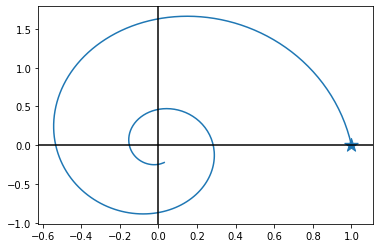

In [18]:
ax = plt.figure().add_subplot(111)
init_path = np.array([s.numpy() for s in y]).reshape(-1,2)
plot_path(init_path, ax, 'init_path')

### Optimization of the Initial State

In [0]:
y0_var = tf.Variable(y0)
yN_target = tf.constant([[0.5, 0.5]])

def tf_train_spiral_init_state(solver, optimizer, yN_target=yN_target):
  yN = solver.forward(y0_var, return_states=False)    
  
  with tf.GradientTape() as tape:
    tape.watch(yN)
    loss = tf.reduce_sum((yN_target-yN)**2)
  
  dL_dyN = tape.gradient(loss, yN)
  y0_reconst, dL_dy0, dL_dW = solver.backward(outputs=yN, output_grads=dL_dyN)
  optimizer.apply_gradients([(dL_dy0, y0_var)]) # update y0 to reduce the loss
  
  return yN[0,0], yN[0,1]

Epoch 1: yN = (0.029571, -0.223137)
Epoch 31: yN = (0.081832, 0.414199)
Epoch 61: yN = (0.172345, 0.506589)
Epoch 91: yN = (0.263999, 0.473982)
Epoch 121: yN = (0.336386, 0.488134)
Epoch 151: yN = (0.392704, 0.490881)
Epoch 181: yN = (0.433154, 0.494567)
Epoch 211: yN = (0.460544, 0.496738)
Epoch 241: yN = (0.477942, 0.498184)
Epoch 271: yN = (0.488334, 0.499039)

Elapsed Time 79.372026 [sec]


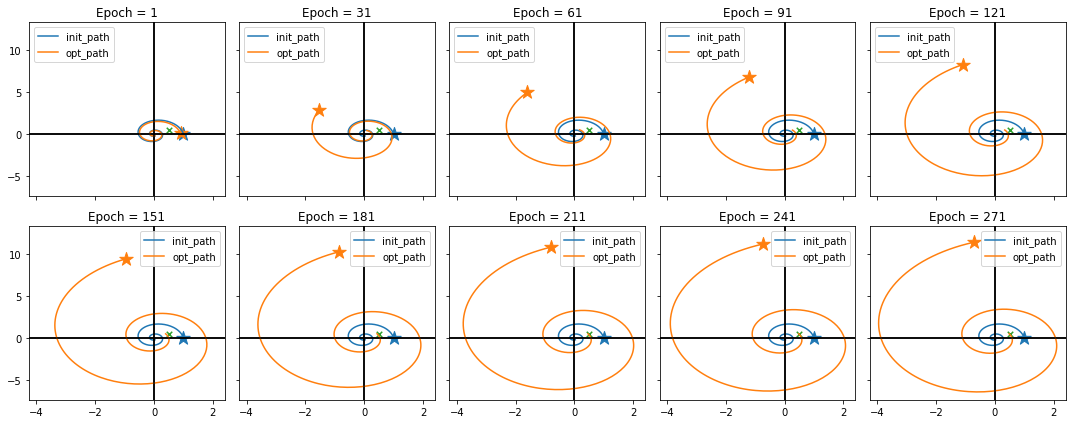

In [20]:
epochs = 301
max_fig = 10

optimizer = tfk.optimizers.Adam(lr=.1)
lst_x0, lst_x1 = [], []

fig, axes = plt.subplots(2, max_fig//2, figsize=[15,6], sharex=True, sharey=True)
axes = np.ravel(axes)
i_fig = 0
fig_step = epochs//max_fig

with measure_time():
  for epoch in range(epochs):
    x0,x1 = tf_train_spiral_init_state(my_solver, optimizer)
    lst_x0.append(x0)
    lst_x1.append(x1)

    if epoch % fig_step == 0 and i_fig < max_fig:
      print('Epoch %i: yN = (%f, %f)'%(epoch+1, x0, x1))

      ax = axes[i_fig]
      y = my_solver.forward(y0_var, return_states=True)
      path = y.numpy().reshape(-1,2)
      
      plot_path(init_path, ax, 'init_path')
      plot_path(path, ax, 'opt_path')
      ax.scatter(yN_target.numpy()[0,0], yN_target.numpy()[0,1], marker='x', s=30)
      ax.set_title('Epoch = %i' % (epoch+1,))
      ax.legend()
      i_fig += 1
plt.tight_layout()
plt.show()

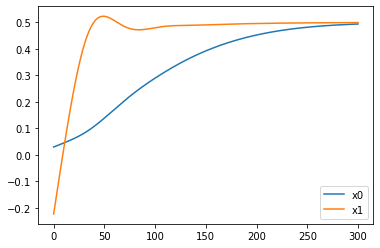

In [21]:
plt.plot(lst_x0,label='x0')
plt.plot(lst_x1,label='x1')
plt.legend()

### Model Learning

In [0]:
class MySpiral(tfk.Model):
  def __init__(self):
    super().__init__()
    self._ls = [tfkl.Dense(16,'tanh'), tfkl.Dense(16,'tanh'), tfkl.Dense(2,'tanh')]

  def call(self, t, x):
    for l in self._ls: x = l(x) # autonomous model
    return x

In [0]:
t = np.linspace(0., 1., 51)
_solver = TfOdeSolver(Sprial(), t, euler_step)
np.random.seed(0)
y0 = tf.Variable(np.random.normal(scale=1., size=(1000,2)), dtype=tf.float32)
targets = _solver.forward(y0, return_states=False)

In [0]:
def tf_train_my_spiral(solver, optimizer, y0=y0, targets=targets):
  preds = solver.forward(y0, return_states=False)    
  
  with tf.GradientTape() as tape:
    tape.watch(preds)
    loss = tf.reduce_mean((targets-preds)**2)
  
  dL_dyN = tape.gradient(loss, preds)
  y0_reconst, dL_dy0, dL_dW = solver.backward(outputs=preds, output_grads=dL_dyN)
  solver.apply_gradients_to_model(optimizer, dL_dW) # update weights to reduce the loss
  
  return loss

In [25]:
optimizer = tfk.optimizers.Adam(learning_rate=.1)
my_model = MySpiral()
my_solver = TfOdeSolver(my_model, t, euler_step)
epochs = 2000

losses = []
with measure_time(), overwriting_stdout():
  for epoch in range(epochs):
    loss = tf_train_my_spiral(my_solver, optimizer)
    sys.stdout.write('Epoch %i: loss = %f'%(epoch+1, loss))
    losses.append(loss)

Epoch 2000: loss = 0.044062
Elapsed Time 427.656429 [sec]


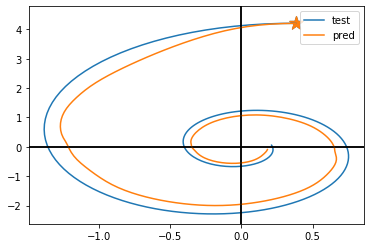

In [26]:
np.random.seed(999)
y0 = tf.Variable(np.random.normal(scale=3., size=(1,2),), dtype=tf.float32)
t = np.linspace(0, 25, 201)

def integrate_spiral(model):
  _solver = TfOdeSolver(model, t, euler_step)
  return _solver.forward(y0, return_states=True).numpy().reshape(-1,2)

y_test = integrate_spiral(Sprial())
y_pred = integrate_spiral(my_model)

ax = plt.figure().add_subplot(111)
plot_path(y_test, ax, label='test')
plot_path(y_pred, ax, label='pred')
plt.legend()

## Example: Minimal Seed

In [0]:
class DynamicalSystem2D(tfk.Model):
  def __init__(self):
    super().__init__()

  def call(self, t, inputs):
    x = inputs[:,0]
    y = inputs[:,1]

    dxdt = -x + 10.*y
    dydt = y * (10.*tf.exp(-x**2/100.) - y) * (y-1.)

    return tf.stack([dxdt, dydt], axis=-1)

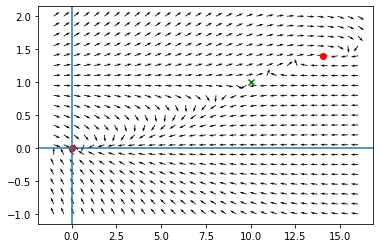

In [28]:
model = DynamicalSystem2D()

x,y = np.meshgrid(np.linspace(-1.,16,31),np.linspace(-1.,2.,21))
z = np.hstack([x.flatten().reshape(-1,1), y.flatten().reshape(-1,1)])

velocity = model(0., tf.Variable(z, tf.float32)).numpy()
norm = np.sqrt(np.sum(velocity**2, axis=-1))
u = np.reshape(velocity[:,0]/norm, x.shape) # to unit vectors
v = np.reshape(velocity[:,1]/norm, x.shape)

plt.quiver(x, y, u, v, units='xy')
plt.scatter(0, 0, marker="o", color='r')
plt.scatter(14.017, 1.4017, marker="o", color='r')
plt.scatter(10, 1, marker="x", color='g')
plt.axvline(0)
plt.axhline(0)

In [0]:
# Find a seed (the initial state having a constant energy)
# that maximizes the energy at t=T,
# where energy is defined by squre of the Euclidean norm

def tf_update_seed(theta0_var, solver, optimizer, state_norm=0.9):

  # Calculate the initial state
  x0 = tf.broadcast_to(theta0_var, shape=(1,2))
  with tf.GradientTape() as tape1:
    tape1.watch(x0)
    a = state_norm*tf.math.cos(x0[0,0])
    b = state_norm*tf.math.sin(x0[0,1])
    y0 = tf.reshape(tf.stack([a,b], axis=-1), shape=(1,2))

  # Integrate and calculate the final state
  yN = solver.forward(y0, return_states=False)    
  
  with tf.GradientTape() as tape2:
    tape2.watch(yN)
    loss = -tf.reduce_sum(yN**2) # to maximize the norm of the final state
  
  # Integrate backwards to calculate gradients
  dL_dyN = tape2.gradient(loss, yN)
  y0_reconst, dL_dy0, dL_dW = solver.backward(outputs=yN, output_grads=dL_dyN)
  
  # Project gradient vector onto 1D sphere
  grads = tape1.gradient(y0, x0)
  unit_vec = grads/(tf.math.sqrt(tf.reduce_sum(grads**2))+1e-8)
  
  grad = tf.reshape(tf.reduce_sum(dL_dy0*unit_vec), theta0_var.shape)
  optimizer.apply_gradients([(grad, theta0_var),])

  return -loss.numpy()

In [30]:
t = np.linspace(0., 1., 1001)
state_norm = 1.1
my_solver = TfOdeSolver(model=DynamicalSystem2D(), t=t, ode_step=euler_step)
optimizer = tfk.optimizers.Adam(lr=.01)

theta0_var = tf.Variable(tf.zeros(1))
epochs = 301
lst_loss = []
lst_theta = []

with measure_time(), overwriting_stdout():
  for epoch in range(epochs):
    loss = tf_update_seed(theta0_var, my_solver, optimizer, state_norm=state_norm)
    lst_loss.append(loss)
    theta = theta0_var.numpy()[0]
    lst_theta.append(360.*theta/(2.*np.pi))

    x = state_norm*np.cos(theta)
    y = state_norm*np.sin(theta)
    sys.stdout.write('Epoch {0}: Final Norm = {1:.5f}, (x0, y0) = ({2:.5f}, {3:.5f}), theta0 ={4:.5f}'\
                     .format(epoch+1, loss, x, y, 360.*theta/(2.*np.pi)))

Epoch 301: Final Norm = 260.44028, (x0, y0) = (0.23851, 1.07383), theta0 =77.47744
Elapsed Time 864.302186 [sec]


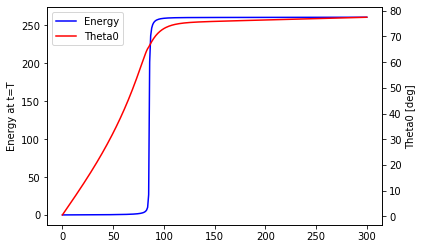

In [31]:
ax = plt.figure().add_subplot(111)
ax.plot(lst_loss, color='b', label='Energy')
ax.set_ylabel('Energy at t=T')
h1, l1 = ax.get_legend_handles_labels()

ax = ax.twinx()
ax.plot(lst_theta, color='r', label='Theta0')
ax.set_ylabel('Theta0 [deg]')
ax.set_xlabel('Epoch')
h2, l2 = ax.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2)

# ODE Solver (TFP)

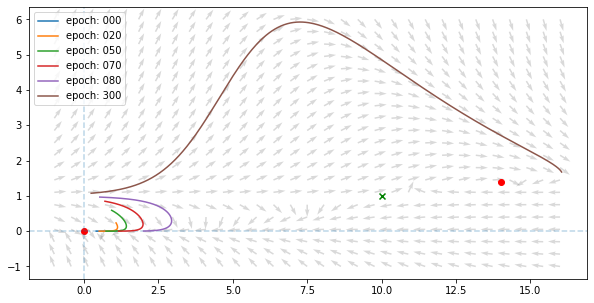

In [32]:
plt.figure(figsize=[10,5])

model = DynamicalSystem2D()

x,y = np.meshgrid(np.linspace(-1.,16,31),np.linspace(-1.,6.,21))
z = np.hstack([x.flatten().reshape(-1,1), y.flatten().reshape(-1,1)])

velocity = model(0., tf.Variable(z, tf.float32)).numpy()
norm = np.sqrt(np.sum(velocity**2, axis=-1))
u = np.reshape(velocity[:,0]/norm, x.shape) # to unit vectors
v = np.reshape(velocity[:,1]/norm, x.shape)

plt.quiver(x, y, u, v, units='xy', width=0.05, alpha=0.15)
plt.scatter(0, 0, marker="o", color='r')
plt.scatter(14.017, 1.4017, marker="o", color='r')
plt.scatter(10, 1, marker="x", color='g')
plt.axvline(0, ls='--', alpha=0.3)
plt.axhline(0, ls='--', alpha=0.3)


for epoch in [0, 20, 50, 70, 80, 300]:
  theta0 = lst_theta[epoch]/360.*2.*np.pi
  x = state_norm*np.cos(theta0)
  y = state_norm*np.sin(theta0)
  states = my_solver.forward(tf.Variable([[x,y],], dtype=tf.float32), return_states=True)
  states = states.numpy().reshape(-1,2)
  plt.plot(states[:,0], states[:,1], label='epoch: {0:0=3}'.format(epoch))
plt.legend(loc='upper left')

## Example: Spiral Model

### Forward Path

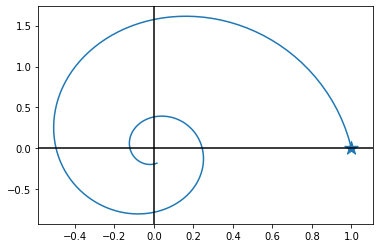

In [33]:
tfp_solver = tfp.math.ode.DormandPrince()
t = np.linspace(0, 25, 201)
y0 = tf.constant([[1., 0.]])

init_result = tfp_solver.solve(ode_fn=Sprial(), initial_time=t[0], initial_state=y0, solution_times=t)
init_path = init_result.states.numpy().reshape(-1,2)
ax = plt.figure().add_subplot(111)
plot_path(init_path, ax, 'init')

### Optimization of the Initial State

In [0]:
y0_var = tf.Variable(y0)
t = np.linspace(0, 25, 201)
yN_target=tf.constant([[0.5, 0.5]])


def tfp_train(solver, model, optimizer, t=t, yN_target=yN_target):
  
  with tf.GradientTape() as tape:
    tape.watch(y0_var)
    
    result = solver.solve(
        ode_fn=model,
        initial_time=t[0], 
        initial_state=y0_var, 
        solution_times=[t[-1]],)    
    
    yN = tf.reshape(result.states[-1], y0_var.shape)
    loss = tf.reduce_sum((yN_target-yN)**2)
  
  dL_dy0 = tape.gradient(loss, y0_var)
  optimizer.apply_gradients([(dL_dy0, y0_var)]) # modify y0 to reduce the loss
  
  return yN[0,0], yN[0,1]

Epoch 1: yN = (0.015069, -0.179644)
Epoch 31: yN = (0.078902, 0.337466)
Epoch 61: yN = (0.152860, 0.512578)
Epoch 91: yN = (0.229880, 0.488787)
Epoch 121: yN = (0.296256, 0.488746)
Epoch 151: yN = (0.351064, 0.492993)
Epoch 181: yN = (0.394821, 0.494682)
Epoch 211: yN = (0.428219, 0.496426)
Epoch 241: yN = (0.452613, 0.497622)
Epoch 271: yN = (0.469858, 0.498489)

Elapsed Time 204.432803 [sec]


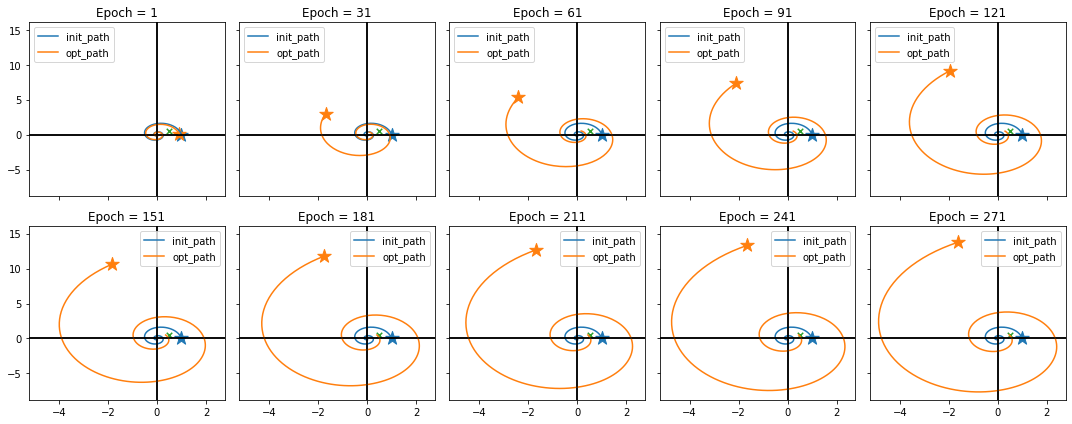

In [35]:
epochs = 301
max_fig = 10

optimizer = tfk.optimizers.Adam(lr=.1)
spiral = Sprial()
lst_x0, lst_x1 = [], []

fig, axes = plt.subplots(2, max_fig//2, figsize=[15,6], sharex=True, sharey=True)
axes = np.ravel(axes)
i_fig = 0
fig_step = epochs//max_fig

with measure_time():
  for epoch in range(epochs):
    x0,x1 = tfp_train(tfp_solver, spiral, optimizer)
    lst_x0.append(x0)
    lst_x1.append(x1)

    if epoch % fig_step == 0 and i_fig < max_fig:
      print('Epoch %i: yN = (%f, %f)'%(epoch+1, x0, x1))

      ax = axes[i_fig]
      _,y,_,_ = tfp_solver.solve(spiral, t[0], y0_var, t)
      path = y.numpy().reshape(-1,2)
      
      plot_path(init_path, ax, 'init_path')
      plot_path(path, ax, 'opt_path')
      ax.scatter(yN_target.numpy()[0,0], yN_target.numpy()[0,1], marker='x', s=30)
      ax.set_title('Epoch = %i' % (epoch+1,))
      ax.legend()
      i_fig += 1
plt.tight_layout()
plt.show()

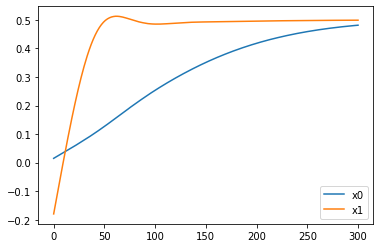

In [36]:
plt.plot(lst_x0,label='x0')
plt.plot(lst_x1,label='x1')
plt.legend()

# References

1. https://arxiv.org/abs/1806.07366
1. https://arxiv.org/abs/1408.3539
1. https://github.com/kmkolasinski/deep-learning-notes/tree/master/seminars/2019-03-Neural-Ordinary-Differential-Equations